# QEC Lab Demo

Contemporary quantum devices are highly error-prone: gates, measurements, and even idle periods can induce bit flips, phase flips, decoherence, and energy relaxation. Quantum error correction (QEC) addresses this by encoding one logical qubit into many physical qubits and using tailored measurements and decoding so that logical information can be recovered even when some physical qubits fail. At the same time, Qiskit’s QEC framework is still in an active development and testing phase, and many existing approaches remain quite abstract—relying on matrices, stabilizers, or heavyweight libraries—so it can be challenging for students to run realistic noisy circuits and directly compare logical and physical error rates in a hands-on way.

The notebook builds and simulates several small quantum error-correcting codes (repetition, Shor, Steane, rotated surface) to compare their logical error rates against a noisy physical-qubit baseline using Qiskit Aer. It also demonstrates the full workflow—from noise-model sweeps to passive decoding visualizations and a simple active-correction loop—so readers can see how different codes suppress bit-flip noise in practice.

## Imports and setup
We import matplotlib for plotting, Qiskit for circuit building, and the helper utilities from the local `qec_lab` package.


In [1]:
# Configure plotting and experiment helpers
import os
import sys

import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

from qec_lab.codes import (
    RepetitionCode3,
    RotatedSurfaceCodeD3,
    ShorCode9,
    SteaneCode7,
)
from qec_lab.experiments.sweep import run_code_on_noise_grid, run_physical_qubit

%matplotlib inline
plt.rcParams["figure.dpi"] = 130
plt.rcParams["figure.figsize"] = (6, 4)


In [2]:
from IPython.display import display

def draw_once(circuit):
    """Render a circuit with Matplotlib exactly once."""
    fig = circuit.draw("mpl")
    display(fig)
    plt.close(fig)



## Quantum error correction workflow
1. Choose a logical state and identify the dominant noise channel.
2. Build an encoding circuit that spreads the logical information across multiple physical qubits.
3. Run the noisy circuit on an Aer simulator to collect measurement statistics.
4. Decode the measurement outcomes into logical values and compare them with the intended logical state to estimate a logical error rate.
The following sections show how this workflow adapts to different codes and noise models.


### Noise models used here

In [3]:
# Helper function
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import matplotlib.pyplot as plt

# Pauli matrices
X = np.array([[0, 1],
              [1, 0]], dtype=complex)
Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)

# Common initial states
zero = Statevector.from_label('0')   # |0>
one  = Statevector.from_label('1')   # |1>
plus = Statevector.from_label('+')   # |+> = (|0> + |1>)/sqrt(2)

def apply_unitary(state, U):
    """Apply a 2x2 unitary matrix U to a 1-qubit Statevector."""
    new_data = U @ state.data
    return Statevector(new_data)

def plot_state(state, title):
    """Plot a single Bloch sphere for a pure state."""
    fig = plot_bloch_multivector(state)
    fig.suptitle(title)
    plt.show()


1. **Bit-flip noise**: every gate can be followed by an `X` error with probability `p`. For example, with `p = 0.02`, applying an `x` gate to `|0⟩` has a 2% chance of flipping again and ending back in `|0⟩`. The repetition code primarily targets this channel.

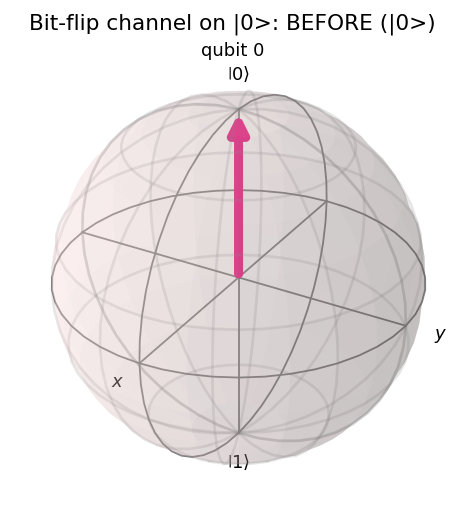

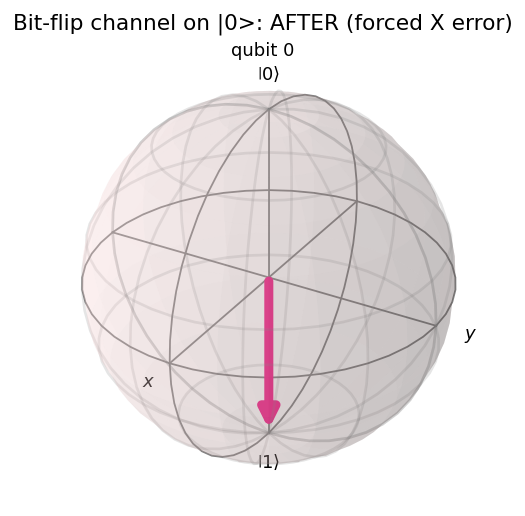

In [4]:
# Bit-flip noise
# BEFORE: perfect |0>
init_state = zero

# AFTER: force one X error: |0> -> |1>
final_state = apply_unitary(init_state, X)

plot_state(init_state, "Bit-flip channel on |0>: BEFORE (|0>)")
plot_state(final_state,
           f"Bit-flip channel on |0>: AFTER (forced X error)")


2. **Phase-flip noise**: identical structure but injects `Z` errors. A Hadamard followed by this noise might return `|+⟩` 98% of the time and randomly apply a `Z` the remaining 2%, turning it into `|-⟩`. The phase-flip code is optimized for this scenario.

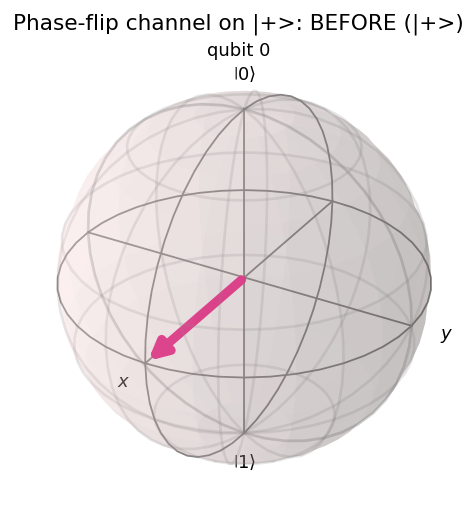

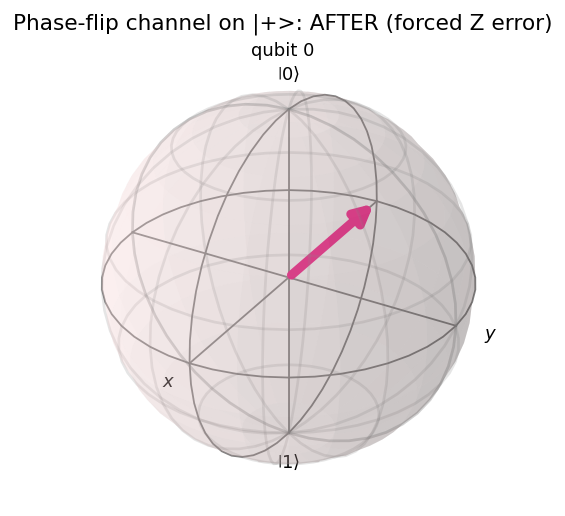

In [5]:
# Phase-flip noise
# BEFORE: |+> = (|0> + |1>)/sqrt(2)
init_state = plus

# AFTER: force one Z error: |+> -> |-> 
final_state = apply_unitary(init_state, Z)

plot_state(init_state, "Phase-flip channel on |+>: BEFORE (|+>)")
plot_state(final_state,
           f"Phase-flip channel on |+>: AFTER (forced Z error)")


3. **Depolarizing noise**: spreads probability `p` evenly over `{X, Y, Z}` errors. With `p = 0.03`, each single-qubit gate has a 1% chance of each Pauli error, capturing generic decoherence. The Shor and rotated-surface codes tackle this mixed channel.
All models come from `qec_lab.noise.models` and plug directly into the Aer simulator via `run_code_on_noise_grid`.

### Monte Carlo sampling with Aer
For each `p`, the Aer simulator executes the circuit `shots` times (4096 by default) under the chosen noise model. Each execution is one Monte Carlo sample. The resulting counts dictionary reports how many samples collapsed to each classical bitstring.

*Example*: with `shots = 1000` and a true physical error rate of 2%, a typical counts dictionary might be `{ '0': 980, '1': 20 }`. The empirical error is `20 / 1000 = 0.02`. Doubling `shots` halves the statistical variance but doubles runtime.

This sampling procedure is identical for the physical baseline and every code; only the decoder changes when mapping raw bitstrings to logical decisions.


## Baseline: single physical qubit
We first examine how a single qubit behaves when every gate is subject to noise with probability `p`. To guarantee that the noise model has a gate to act on, we prepare `|1⟩` by applying an `x` gate even though no error correction is used.


In [6]:
ps = [0.001, 0.005, 0.01, 0.02, 0.05]
shots = 4096

baseline_bitflip = {
    p: run_physical_qubit(p, logical_state="1", shots=shots, noise_type="bit_flip")
    for p in ps
}
baseline_depolarizing = {
    p: run_physical_qubit(p, logical_state="1", shots=shots, noise_type="depolarizing")
    for p in ps
}
amplitude_damping = {
    p: run_physical_qubit(p, logical_state="1", shots=shots, noise_type="amplitude_damping")
    for p in ps
}

print("Bit-flip baseline:", baseline_bitflip)
print("Depolarizing baseline:", baseline_depolarizing)
print("Amplitude-damping baseline:", amplitude_damping)

Bit-flip baseline: {0.001: 0.000732421875, 0.005: 0.005859375, 0.01: 0.014404296875, 0.02: 0.021240234375, 0.05: 0.04833984375}
Depolarizing baseline: {0.001: 0.0009765625, 0.005: 0.002685546875, 0.01: 0.004638671875, 0.02: 0.008544921875, 0.05: 0.025146484375}
Amplitude-damping baseline: {0.001: 0.001220703125, 0.005: 0.00439453125, 0.01: 0.0107421875, 0.02: 0.022705078125, 0.05: 0.045654296875}


### Interpreting the physical baseline
The resulting physical curves quantify how often a lone qubit flips (or dephases) without any parity checks. Every code must beat its corresponding baseline to justify its overhead.


### Baseline circuit diagram
This circuit prepares `|1⟩` and measures immediately, serving as a reference for all Monte Carlo sweeps.


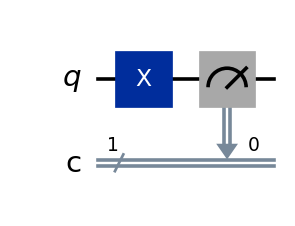

In [7]:
# Baseline circuit with a single physical qubit (no ancilla)
def build_physical_qubit_circuit(logical_state: str = "0") -> QuantumCircuit:
    circuit = QuantumCircuit(1, 1)
    if logical_state == "1":
        circuit.x(0)
    circuit.measure(0, 0)
    return circuit

baseline_circuit = build_physical_qubit_circuit("1")
draw_once(baseline_circuit)


## Parity checks and ancilla syndrome extraction
All of the following codes rely on parity checks to learn about errors without measuring the logical qubit directly. Ancilla qubits interact with selected data qubits, accumulate parity information, and are then measured to yield syndrome bits that hint at where faults occurred.


### Ancilla-assisted parity-check circuit
Two data qubits share one ancilla to sense a single bit flip via an even-parity measurement.


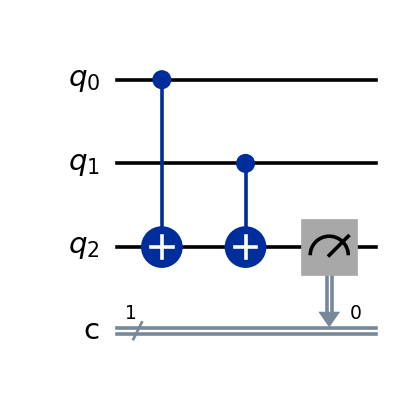

In [8]:
# Two data qubits plus one ancilla for an even-parity check
def build_parity_check_circuit() -> QuantumCircuit:
    circuit = QuantumCircuit(3, 1)
    circuit.cx(0, 2)  # Map the first data qubit parity into the ancilla
    circuit.cx(1, 2)  # Combine with the second data qubit
    circuit.measure(2, 0)  # Measure the ancilla syndrome bit
    return circuit

parity_circuit = build_parity_check_circuit()
draw_once(parity_circuit)


#### What parity checks capture
A parity check detects whether an even or odd number of data qubits flipped without revealing the encoded logical value. By entangling data qubits with an ancilla and measuring only the ancilla, we learn a *syndrome* bit that flags where an error might have occurred. Repetition, Shor, and surface-code-style constructions all string together such parity checks to localize faults while keeping the logical qubit coherent.


#### Why ancilla qubits are needed
Measuring a data qubit directly would collapse its superposition and halt the computation, so we cannot inspect intermediate states. Instead, dedicated ancillas gather the parity information and can be measured without disturbing the logical encoding. Classical post-processing (or feedback in an active scheme) uses these syndrome bits to decide on corrections.


## 3-qubit repetition code (bit-flip protection)
The repetition code encodes $|0_L\rangle = |000\rangle$ and $|1_L\rangle = |111\rangle$, so a single bit flip can be corrected with a majority vote. It excels under pure bit-flip noise.


### Circuit and decoder details
1. Prepare the logical state on the first qubit, then entangle it with two more via CNOTs.
2. Run the circuit under bit-flip noise so each gate can suffer random $X$ errors.
3. Measure all three qubits and use majority voting to decode the logical value.
4. Compare against the intended logical bit to estimate the logical error probability.


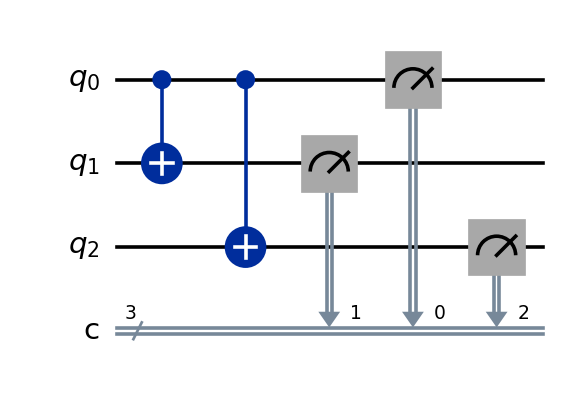

In [9]:
repetition_code = RepetitionCode3()
draw_once(repetition_code.build_circuit("0"))


In [10]:
repetition_results = run_code_on_noise_grid(
    repetition_code,
    ps,
    noise_type="bit_flip",
    shots=shots,
)


[3-qubit repetition code | noise=bit_flip] p=0.0010, logical error=0.0024
[3-qubit repetition code | noise=bit_flip] p=0.0050, logical error=0.0076
[3-qubit repetition code | noise=bit_flip] p=0.0100, logical error=0.0120
[3-qubit repetition code | noise=bit_flip] p=0.0200, logical error=0.0210
[3-qubit repetition code | noise=bit_flip] p=0.0500, logical error=0.0479


## 9-qubit Shor code
Shor's code stacks protections: it first duplicates the logical qubit across three blocks to protect against phase errors, then applies three-qubit repetition within each block to catch bit flips. This construction can correct any single-qubit error under depolarizing noise.


### Circuit and decoder details
1. Spread the logical qubit across three blocks via CNOTs and Hadamards.
2. Within each block, apply two additional CNOTs to form three-qubit repetition codes.
3. Measure all nine data qubits.
4. Majority vote within each block (bit-flip protection) and then majority vote across the three block values (phase-flip protection).


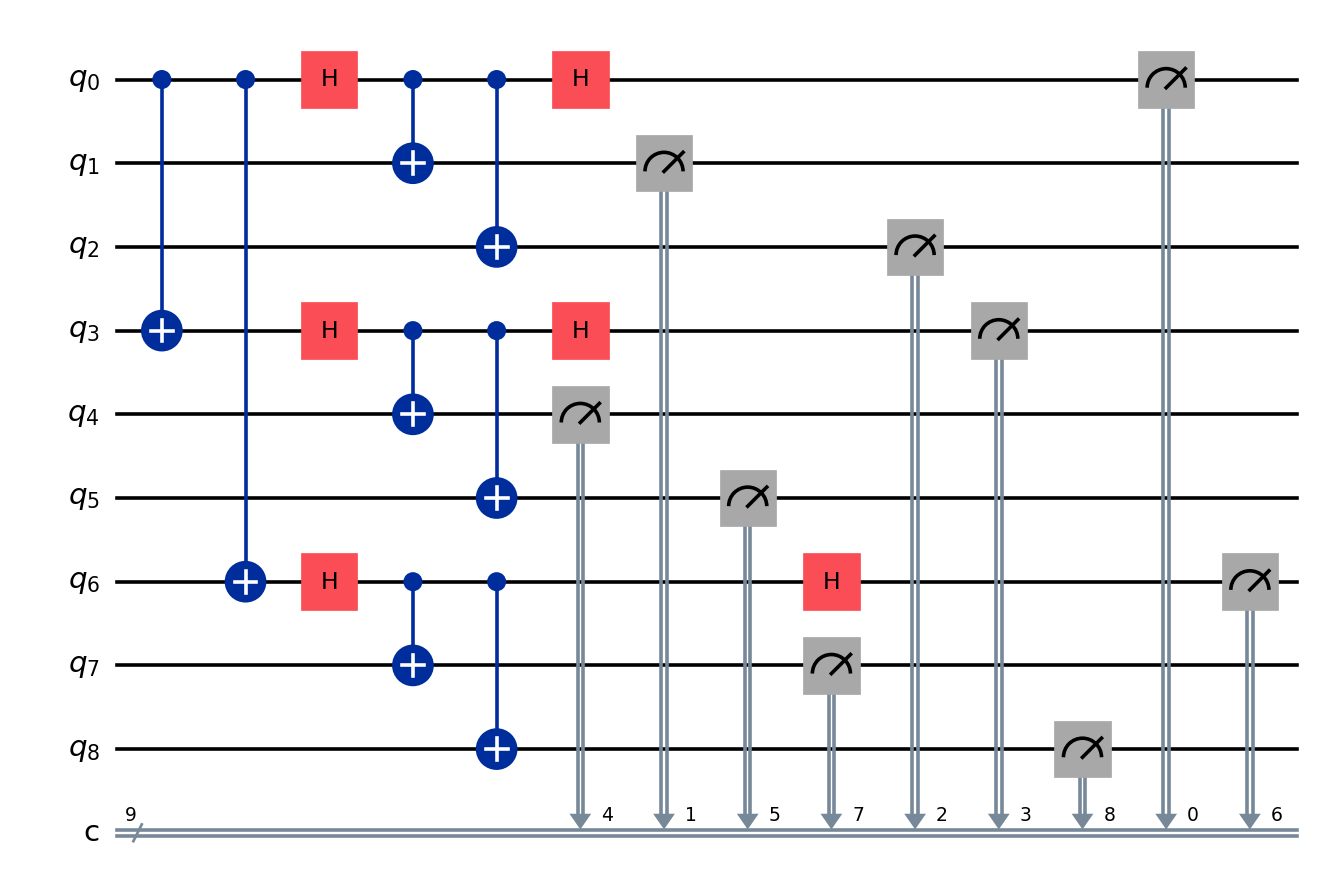

In [11]:
shor_code = ShorCode9()
draw_once(shor_code.build_circuit("0"))


In [12]:
shor_results = run_code_on_noise_grid(
    shor_code,
    ps,
    noise_type="depolarizing",
    shots=shots,
)


[9-qubit Shor code | noise=depolarizing] p=0.0010, logical error=0.5071
[9-qubit Shor code | noise=depolarizing] p=0.0050, logical error=0.4966
[9-qubit Shor code | noise=depolarizing] p=0.0100, logical error=0.4956
[9-qubit Shor code | noise=depolarizing] p=0.0200, logical error=0.4929
[9-qubit Shor code | noise=depolarizing] p=0.0500, logical error=0.4873


## 7-qubit Steane code

The Steane code is a CSS stabilizer code built from the classical \([7,4,3]\) Hamming code.  
It encodes $|0_L\rangle$ and $|1_L\rangle$, as equal superpositions of 8 classical codewords and, in
principle, can correct any single-qubit Pauli error. In this demo we focus on pure bit-flip noise and
use passive classical Hamming decoding on the final 7-bit \(Z\)-basis measurement outcomes.


### Circuit and decoder details

1. Use a Steane encoder (Hadamards + CNOTs) to prepare $|0_L\rangle$ and $|1_L\rangle$ on seven data qubits.  
2. Run the circuit under bit-flip noise so each gate can suffer random \(X\) errors.  
3. Measure all seven qubits in the \(Z\) basis to obtain a 7-bit classical string.  
4. Treat this string as a noisy Hamming \([7,4,3]\) codeword: find the nearest even-weight or odd-weight
   Steane codeword and decode the corresponding logical bit.  
5. Compare the decoded logical bit with the intended one to estimate the logical error probability.


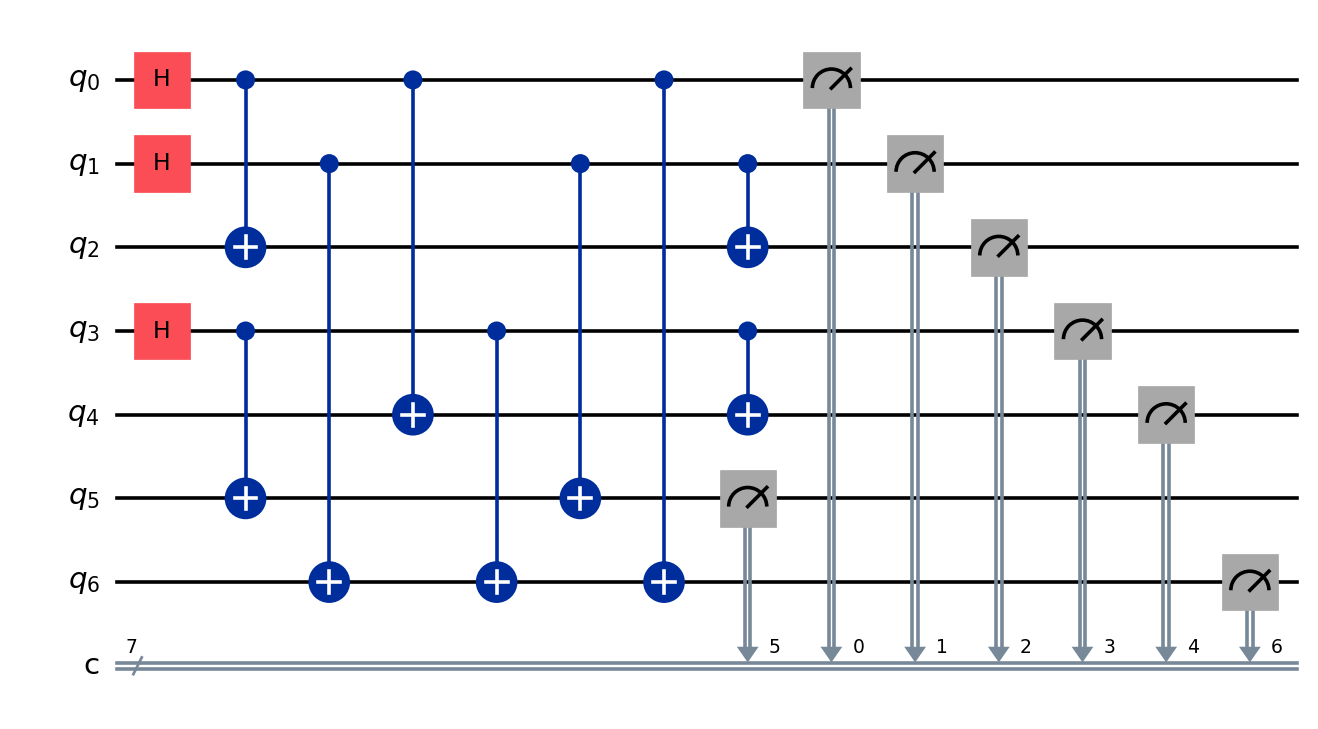

In [13]:
steane_code = SteaneCode7()
draw_once(steane_code.build_circuit("0"))


In [14]:
steane_results = run_code_on_noise_grid(
    steane_code,
    ps,
    noise_type="bit_flip",
    shots=shots,
)


[7-qubit Steane code | noise=bit_flip] p=0.0010, logical error=0.0029
[7-qubit Steane code | noise=bit_flip] p=0.0050, logical error=0.0139
[7-qubit Steane code | noise=bit_flip] p=0.0100, logical error=0.0317
[7-qubit Steane code | noise=bit_flip] p=0.0200, logical error=0.0706
[7-qubit Steane code | noise=bit_flip] p=0.0500, logical error=0.1958


## d=3 rotated surface code
This toy rotated surface code arranges nine data qubits in a $3\times 3$ grid and uses eight ancilla qubits to measure X- and Z-type stabilizers (parity checks). It demonstrates how surface-code-style decoders combine information from overlapping checks without performing active corrections.


### Circuit and decoder details
- Entangle the logical qubit with all nine data qubits to mimic a distance-3 patch.
- X-type stabilizers prepare ancillas in $|+\rangle$, entangle them with four neighboring data qubits, and measure to learn bit-flip syndromes.
- Z-type stabilizers use standard CNOT parity checks to capture phase errors.
- The passive decoder forms majority votes across rows and columns of the $3\times 3$ data lattice (using the measured data bits) to decide the logical outcome; this mirrors how surface-code decoders infer logical flips from overlapping syndromes.


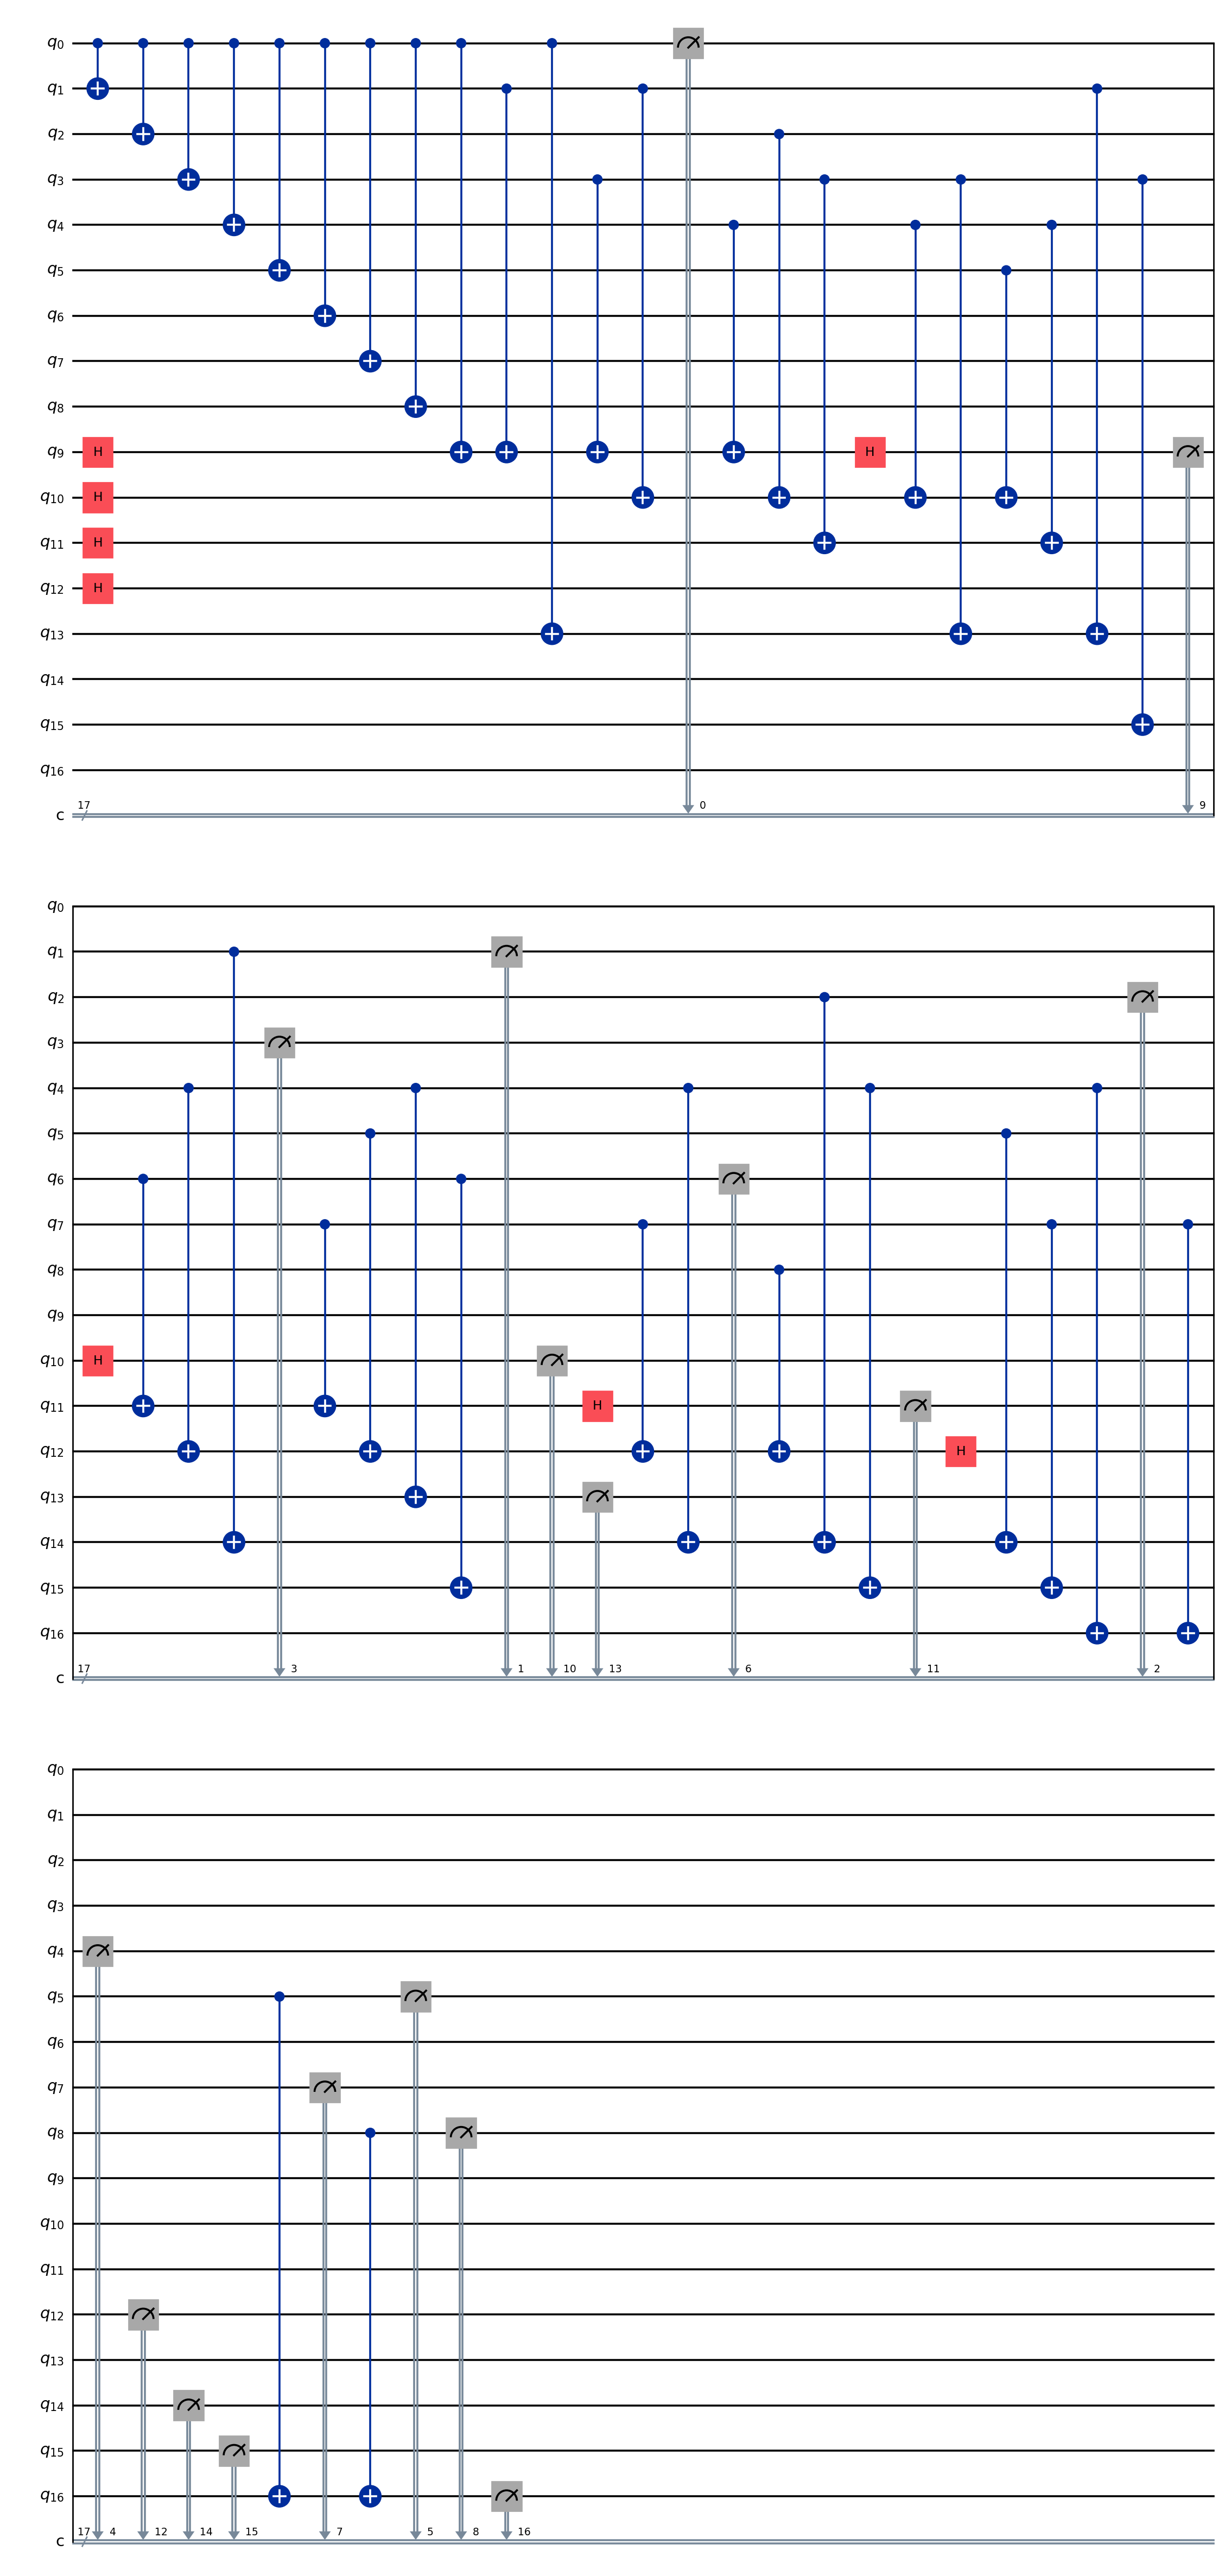

In [15]:
rotated_code = RotatedSurfaceCodeD3()
draw_once(rotated_code.build_circuit("0"))


In [16]:
rotated_results = run_code_on_noise_grid(
    rotated_code,
    ps,
    noise_type="depolarizing",
    shots=shots,
)


[d=3 rotated surface code | noise=depolarizing] p=0.0010, logical error=0.0037
[d=3 rotated surface code | noise=depolarizing] p=0.0050, logical error=0.0127
[d=3 rotated surface code | noise=depolarizing] p=0.0100, logical error=0.0198
[d=3 rotated surface code | noise=depolarizing] p=0.0200, logical error=0.0459
[d=3 rotated surface code | noise=depolarizing] p=0.0500, logical error=0.1091


## Decoder logic across the featured codes
- **3-qubit repetition**: majority vote on the three measured bits after bit-flip noise. Parity checks implicitly ensure two bits agree on the correct value.
- **9-qubit Shor code**: majority vote inside each of the three-bit blocks (detecting bit flips) followed by a second majority vote across the three blocks (detecting phase flips).
- **7-qubit Steane code**: interpret each 7-bit Z-basis measurement as a noisy $[7,4,3]$ Hamming codeword and use classical Hamming decoding to infer the logical bit.
- **d=3 rotated surface code**: parity checks span a $3\times 3$ data grid. Decoding combines majority votes across rows and columns to mimic a surface-code minimum-weight perfect-matching routine in a simplified, passive form.
Each decoder here is passive: it interprets the measurement results to infer the logical bit but does not actively correct the data qubits mid-circuit.


## Comparing logical vs physical error rates
Each subplot compares a physical baseline curve against the logical error rates of the codes tailored for that noise channel.


### Bit-flip noise comparison
The first plot contrasts the single physical qubit under bit-flip noise with the 3-qubit repetition code, highlighting how majority voting suppresses errors when `p` is small.


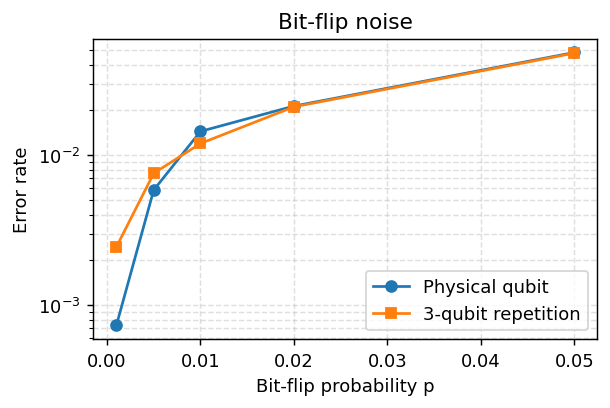

In [17]:
plt.figure(figsize=(5, 3))
plt.plot(ps, [baseline_bitflip[p] for p in ps], marker="o", label="Physical qubit")
plt.plot(ps, [repetition_results[p] for p in ps], marker="s", label="3-qubit repetition")
plt.yscale("log")
plt.xlabel("Bit-flip probability p")
plt.ylabel("Error rate")
plt.title("Bit-flip noise")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


### Depolarizing noise comparison
Both the 9-qubit Shor code and the rotated surface code tackle mixed Pauli errors. Their logical curves fall below the physical baseline for small `p`, though the surface code uses passive decoding for simplicity.


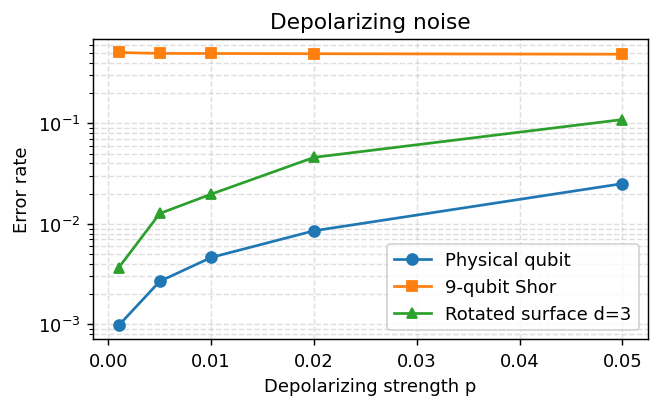

In [18]:
plt.figure(figsize=(5.5, 3))
plt.plot(ps, [baseline_depolarizing[p] for p in ps], marker="o", label="Physical qubit")
plt.plot(ps, [shor_results[p] for p in ps], marker="s", label="9-qubit Shor")
plt.plot(ps, [rotated_results[p] for p in ps], marker="^", label="Rotated surface d=3")
plt.yscale("log")
plt.xlabel("Depolarizing strength p")
plt.ylabel("Error rate")
plt.title("Depolarizing noise")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


- This notebook only demonstrates the simplest passive setting: every code faces bit-flip noise, so the focus is on illustrating the workflow rather than squeezing optimal performance.
- Moreover, since QEC only becomes relevant when the system is scaled to a larger number of qubits, the results of this experiment are of limited practical relevance.
- Realistic fault-tolerance studies would broaden the noise model, insert active correction cycles, and tune decoders; here we stay in the minimal bit-flip regime so each circuit and count table can be followed by hand.

## Active error correction with the 3-qubit repetition code
This final dynamic-circuit demo walks through a full cycle: (1) encode a logical qubit into three data qubits, (2) insert a known single bit flip, (3) measure the two $Z$-type stabilizers with ancillas, (4) decode the two-bit syndrome in classical logic, (5) apply the conditional correction, and (6) measure the data qubits to verify that the original logical state is recovered.


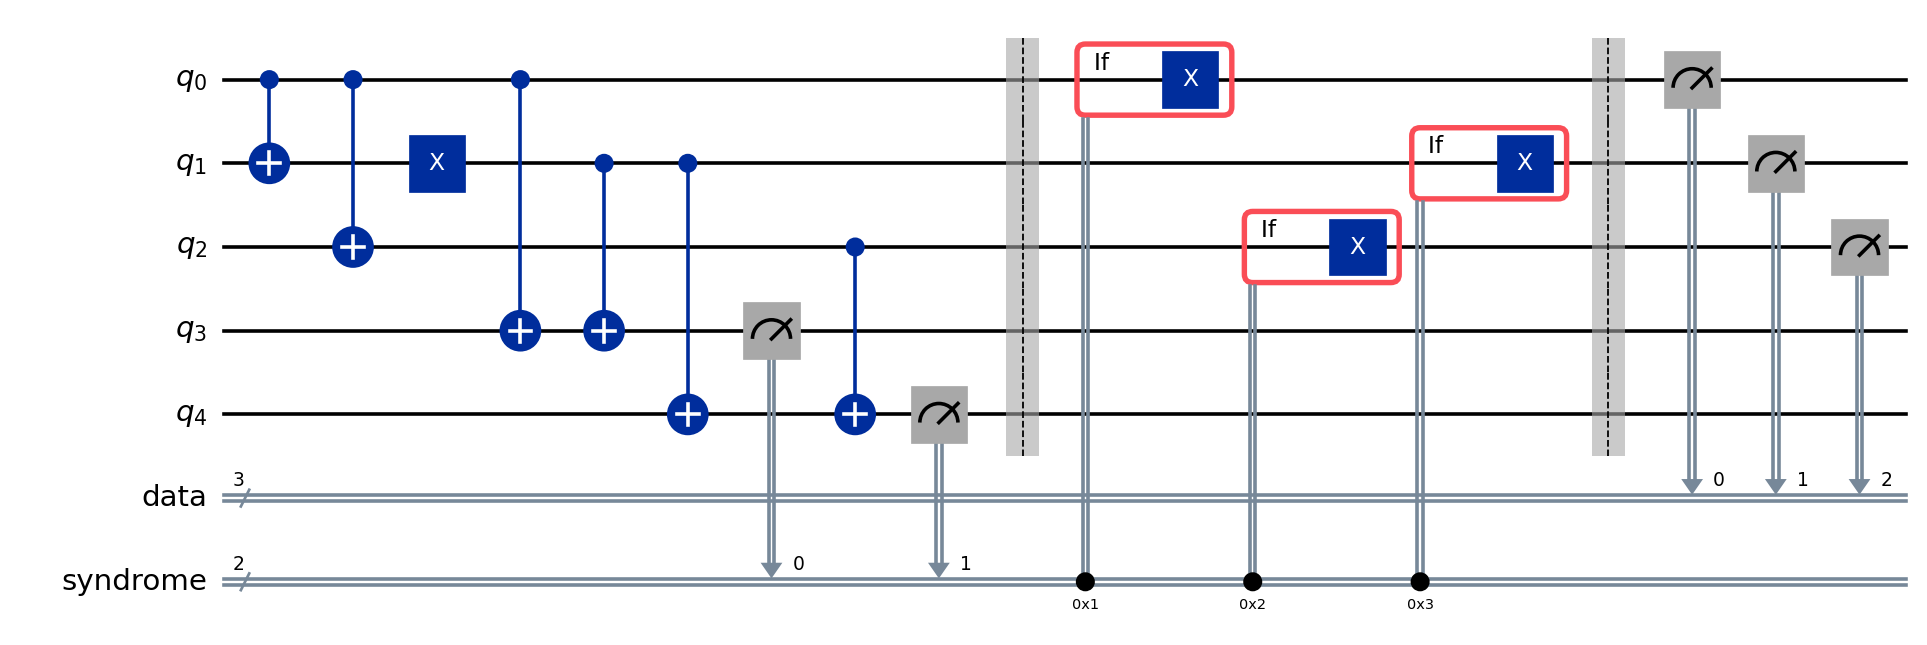

[Active demo] logical=0, error_qubit=1, success=1.000
Data-register counts: {'000': 1024}
Success probability for 000: 1.000


In [19]:
from qec_lab.experiments import (
    build_repetition3_active_correction_circuit,
    run_active_correction_demo,
)

active_circuit = build_repetition3_active_correction_circuit(
    logical_state="0", error_qubit=1
)
draw_once(active_circuit)

shots = 1024
data_counts = run_active_correction_demo(
    logical_state="0", error_qubit=1, shots=shots
)
ideal = "000"
success = data_counts.get(ideal, 0) / shots
print(f"Success probability for {ideal}: {success:.3f}")
